# 0212 - Data preprocessing
- 대용량 데이터를 효율적으로 처리할수 있는 파이프라인 구축 및 데이터 전처리 시도 4
- 승순님 파이프라인코드에서 tf.data.Dataset from generator 사용 시도

# 💡 데이터 파이프라인 구축

- 이 코드의 목적은 대용량 데이터를 메모리나 연산적 효율성을 위해 모델에게 입력하는 파이프라인을 구축하는 것입니다.
- 각 과정을 설명하자면
1. 원본 데이어(csv파일)의 파일명으로 'word' 값 즉, label값의 리스트를 만듭니다.
2. Img_data_generator에 사용될 csv파일의 drawing 컬럼의 좌표값으로 이미지를 시각화 하는 함수(draw_strokes)를 생성합니다.
3. 정제된 `*.gz 파일`에서 drawing컬럼의 좌표값과 y값(label번호)를 추출해 지정한 batch_size만큼 추출데 데이터셋으로 만들어 주는 제너레이터(Img_data_generator)를 생성합니다.
4. Img_data_generator 를 사용해 제너레이서 인스턴스(제너레이터 설정값)를 설정하고 모델에 데이터를 입력합니다.

### STEP 00. 데이터의 label 추출하기

- gz로 경량화 시킨 파일들을 모델에 학습시킬 경우에 각각의 이미지에 대한 라벨값을 입력해줘야 합니다.
- 원본 csv에서느 'word' 라는 컬럼에 이 값이 있지만, 데이터를 경량화 하는 과정에서 이를 'y' 라는 컬럼의 숫자값으로 변형을 했습니다.
- 따라서 모델 입력시에 다시 word 값을 입력해주기 위해 사전에 label의 이름들을 저장해두어야 합니다.
- 이를 위해 csv파일의 파일명을 사용해 label_names 라는 list를 생성합니다.

In [1]:
# 라이브러리 가져오기
import pandas as pd  # pandas 라이브러리를 pd로 가져오기
import numpy as np   # numpy 라이브러리를 np로 가져오기
import os           # os 라이브러리 가져오기
import json         # json 라이브러리 가져오기
import cv2          # OpenCV 라이브러리 가져오기
import tensorflow as tf  # TensorFlow 라이브러리 가져오기
from tensorflow.keras.utils import to_categorical  # TensorFlow의 to_categorical 함수 가져오기

- 사용자 입력을 통해 데이터 폴더(`train_simplified` 또는 `train_raw`)를 선택하고, 해당 폴더 내의 `.csv` 파일 목록을 가져옵니다. 
- 이 파일 목록을 사용하여 레이블 이름(`label_names`) 리스트를 생성하고, 이 리스트의 길이를 출력합니다. 
- 사용자가 올바른 선택을 하지 않을 경우, 기본적으로 `train_simplified` 폴더가 선택됩니다.

In [2]:
# train_simplified 폴더의 경로를 설정합니다.
data_folder_path = '../data'
input_choice = int(input(" train_simplified를 선택하려면 1을, train_raw를 선택하려면 2를 입력하세요: "))

if input_choice == 1:
    train_file_path = os.path.join(data_folder_path, 'train_simplified')
elif input_choice == 2:
    train_file_path = os.path.join(data_folder_path, 'train_raw')
else:
    print("올바른 선택이 아닙니다. 기본적으로 train_simplified 폴더를 선택합니다.")
    train_file_path = os.path.join(data_folder_path, 'train_simplified')

# train_simplified 폴더 내의 파일 목록을 가져옵니다.
# shuffle_raw_gzs 폴더는 무시
train_csvs = [file for file in os.listdir(train_file_path) if file.endswith('.csv')]
print("train_simplified 폴더 내 파일 수:", len(train_csvs))
print(train_csvs[:5])

# .csv 확장자를 제외한 파일명을 사용하여 label_names 리스트를 생성합니다.
label_names = [file.replace('.csv', '') for file in train_csvs]
print(label_names[:5])

# label_names 리스트의 총 개수를 출력합니다.
print("label_names의 총 개수:", len(label_names))

 train_simplified를 선택하려면 1을, train_raw를 선택하려면 2를 입력하세요: 1
train_simplified 폴더 내 파일 수: 340
['cruise_ship.csv', 'coffee_cup.csv', 'spreadsheet.csv', 'scissors.csv', 'belt.csv']
['cruise_ship', 'coffee_cup', 'spreadsheet', 'scissors', 'belt']
label_names의 총 개수: 340


In [4]:
import pickle

# label_names를 파일로부터 로드합니다.
with open('label_names.pkl', 'rb') as f:
    label_names = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'label_names.pkl'

### STEP 01. drawing 컬럼의 좌표값으로 이미지를 그리는 함수

- 이 함수는 `raw_strokes` (원시 획 데이터)를 입력으로 받아, 지정된 이미지 크기(`image_size`)와 선 두께(`line_width`)를 사용하여 이미지를 생성합니다. 
- 입력된 획 데이터는 NumPy 배열로 변환되며, 각 획의 최소 및 최대 x, y 좌표를 계산하여 이미지의 경계를 결정합니다. 
- 이후, 계산된 비율에 따라 모든 획의 좌표를 조정하고, OpenCV의 `cv2.line` 함수를 사용하여 선을 그립니다. 
- 최종적으로 조정된 좌표에 따라 그려진 이미지를 반환합니다. 
- 이 과정을 통해, 원본파일의 drawings 컬럼의 좌표값 데이터(stroke)를 이미지형태로 변환할 수 있습니다.

In [3]:
def draw_strokes(raw_strokes, image_size=128, line_width=6):
    border_offset = line_width * 2  # 테두리 공백 크기
    stroke_list = []  # raw_strokes를 NumPy 배열로 변환한 리스트
    bounds_info = {"min_x": float('inf'), "min_y": float('inf'),  # 최소 x, y 좌표 초기화
                   "max_x": float('-inf'), "max_y": float('-inf')}  # 최대 x, y 좌표 초기화
    
    # raw_strokes의 각 stroke에 대해 NumPy 배열로 변환하고 경계 좌표 갱신
    for stroke in raw_strokes:
        np_stroke = np.array(stroke)  # stroke를 NumPy 배열로 변환
        stroke_list.append(np_stroke)    # 변환된 배열을 stroke_list에 추가
        # 최소/최대 x, y 좌표 갱신
        bounds_info["min_x"] = min(bounds_info["min_x"], min(np_stroke[0]))
        bounds_info["max_x"] = max(bounds_info["max_x"], max(np_stroke[0]))
        bounds_info["min_y"] = min(bounds_info["min_y"], min(np_stroke[1]))
        bounds_info["max_y"] = max(bounds_info["max_y"], max(np_stroke[1]))
    
    # 빈 이미지 생성
    new_image = np.zeros((image_size, image_size, 3), dtype=float)
    original_width = bounds_info["max_x"] - bounds_info["min_x"]  # 원본 그림의 너비
    original_height = bounds_info["max_y"] - bounds_info["min_y"]  # 원본 그림의 높이
    ratio = max(original_width, original_height) / (image_size - border_offset * 2)  # 비율 계산
    
    # 비율이 0일 경우 빈 이미지 반환
    if ratio == 0:
        return new_image

    # 각 stroke의 좌표를 새로운 크기에 맞게 조정하여 이미지에 그리기
    for np_stroke in stroke_list:
        np_stroke[0] = (np_stroke[0] - bounds_info["min_x"]) / ratio + border_offset  # x 좌표 조정
        np_stroke[1] = (np_stroke[1] - bounds_info["min_y"]) / ratio + border_offset  # y 좌표 조정
        # 선 그리기
        for i in range(len(np_stroke[0]) - 1):
            start_x, start_y = int(np_stroke[0][i]), int(np_stroke[1][i])  # 시작점 좌표
            end_x, end_y = int(np_stroke[0][i + 1]), int(np_stroke[1][i + 1])  # 끝점 좌표
            new_image = cv2.line(new_image, (start_x, start_y), (end_x, end_y), (255, 255, 255), line_width)  # 선 그리기
    
    return new_image  # 완성된 이미지 반환

### STEP 2. 데이터를 불러와 모델에 입력하는 제너레이터(Img_data_generator) 생성

- Img_data_generator는 이미지 데이터를 모델에 공급하기 위해 만든 커스텀 제너레이터 입니다.
- 이 클래스는 다음과 같이 구성되어 있습니다

---

#### Simple ver 설명
- `Img_data_generator` 클래스는 TensorFlow의 `tf.keras.utils.Sequence`를 상속받아 이미지 데이터 생성을 위한 사용자 정의 데이터 제너레이터를 구현합니다. 
- 이 클래스는 초기화 시 데이터프레임 파일 리스트, 입력 이미지의 모양, 배치 크기, 레이블 이름, 선의 너비, 상태(Train 또는 Test), 그리고 스무딩 팩터를 매개변수로 받습니다. 
- `__getitem__` 메소드를 통해 배치 단위로 데이터를 처리하며, `on_epoch_end` 메소드는 에폭이 종료될 때마다 호출되어 데이터를 섞거나 다음 파일로 이동하는 등의 작업을 수행합니다. 
- 또한, `smooth_labels` 메소드는 레이블 스무딩 기법을 적용하여 모델의 일반화 성능을 향상시키는 데 사용됩니다.
---

#### Detailed ver 설명

- 1. `__init__`
    - 클래스를 초기화하는 메서드로, 데이터프레임 파일 리스트, 입력 이미지 모양, 배치 크기, 레이블 이름 등을 인자로 받습니다. 
    - 데이터셋을 준비하고 초기화 작업을 수행합니다.

- 2. `smooth_labels`: 
    - 레이블을 부드럽게 만들기 위한 메서드로, 레이블 스무딩을 적용합니다. 
    - 이는 모델의 안정성을 향상시키고 성능을 향상시키는 데 도움이 됩니다.

- 3. `__len__` : 
    - 데이터셋의 길이를 반환합니다. 이는 epoch 종료 조건을 설정하는 데 사용됩니다.

- 4. `__getitem__`: 
    - 주어진 인덱스에 해당하는 데이터를 가져오는 메서드입니다. 
    - 배치 인덱스를 계산하고 입력 이미지와 레이블을 생성하여 반환합니다.

- 5. `on_epoch_end`: 
    - epoch이 종료될 때 호출되는 메서드로, 데이터프레임 파일을 다시 읽고 인덱스를 업데이트합니다.

---
- 이 클래스는 다음과 같은 목적으로 구성되었습니다:

- 1. 이미지 데이터셋을 효율적으로 처리하고 모델에 공급하기 위해.
- 2. 데이터셋을 배치 단위로 처리하고, 필요에 따라 레이블을 스무딩하여 모델 학습에 사용할 수 있도록 하기 위함


---

- 사용법은 다음과 같습니다:

1. 데이터 파일을 준비합니다. 이 파일들은 데이터프레임 형식이며, 이미지 데이터 및 해당 레이블 정보를 포함해야 합니다.
    - 해당 데이터는 이미 `[공통] preprocessing_train_df.ipynb` 파일에서 구현되어있고, 데이터셋으로 만들어져 있습니다.
2. Img_data_generator 클래스의 인스턴스를 생성합니다. 이때 데이터 파일 경로, 입력 이미지 모양, 배치 크기, 레이블 이름 등을 설정합니다.
3. 생성된 제너레이터 인스턴스를 모델의 fit 또는 evaluate 메서드의 데이터 인자로 전달하여 모델 학습 또는 평가에 사용합니다.
4. 모델 학습 후에는 학습된 모델을 사용하여 새로운 데이터에 대한 예측을 수행할 수 있습니다.

---

In [4]:
# 이미지 데이터 생성을 위한 클래스 정의
class Img_data_generator(tf.keras.utils.Sequence):
    def __init__(self, df_files, input_shape, batchsize, label_names, lw=3, state='Train', smoothing_factor=0.1):
        # 클래스 초기화 함수
        self.df_files = df_files  # 데이터프레임 파일 리스트
        self.file_sel = 0  # 현재 사용할 파일 인덱스
        self.batchsize = batchsize  # 배치 크기
        self.input_shape = input_shape  # 입력 이미지 모양
        self.label_names = label_names  # 레이블 이름
        self.lw = lw  # 선의 너비
        self.state = state  # 상태 (Train, Test)
        self.smoothing_factor = smoothing_factor  # 스무딩 팩터
        self.on_epoch_end()  # epoch 종료시 호출

    # 레이블을 부드럽게 만드는 함수
    def smooth_labels(self, labels):
        labels *= (1 - self.smoothing_factor)  # 스무딩 적용
        labels += (self.smoothing_factor / len(self.label_names))  # 스무딩 팩터에 따라 레이블 조정
        return labels

    # 데이터셋의 길이 반환
    def __len__(self):
        return -(-len(self.df) // self.batchsize)  # 데이터셋 길이 계산

    # 주어진 인덱스에 해당하는 데이터 가져오기
    def __getitem__(self, index):
        batch_idx = self.idx[index * self.batchsize:(index + 1) * self.batchsize]  # 배치 인덱스 계산
        h, w, ch = self.input_shape  # 이미지 모양
        X = np.zeros((len(batch_idx), h, w, ch))  # 입력 이미지 배열 초기화
        y = np.zeros((len(batch_idx), len(self.label_names)))  # 레이블 배열 초기화

        for i, idx in enumerate(batch_idx):
            row = self.df.iloc[idx]  # 데이터프레임에서 행 가져오기
            raw_strokes = json.loads(row['drawing'])  # 그림 정보 가져오기
            X[i, :, :, ] = draw_strokes(raw_strokes, image_size=h, line_width=self.lw)  # 그림 그리기

            if self.state != 'Test':
                label_index = row['y']  # 레이블 인덱스
                label = to_categorical(label_index, num_classes=len(self.label_names))  # 원-핫 인코딩된 레이블
                y[i, :] = self.smooth_labels(label)  # 부드럽게 된 레이블 저장

        return (X, y) if self.state != 'Test' else X  # 테스트 상태가 아니면 입력과 레이블 반환, 아니면 입력만 반환

    # epoch 종료시 호출되는 함수
    def on_epoch_end(self):
        self.df = pd.read_csv(self.df_files[self.file_sel])  # 데이터프레임 파일 읽기
        self.idx = np.tile(np.arange(len(self.df)), 2)  # 인덱스 확장
        if self.state == 'Train':
            np.random.shuffle(self.idx)  # 훈련 상태인 경우 인덱스를 섞음
        self.file_sel = (self.file_sel + 1) % len(self.df_files)  # 다음 파일 인덱스 설정

- 추가로 제너레이터에서 label에 Label smoothing 을 적용했습니다.
- 이유는 데이터자체가 워낙 크기 때문에 1epoch만으로도 모델이 과적합이 될 수 있다고 생각해서 입니다.
- 가장 기본적인 목적은 모델이 특정 Label에 대한 `너무 강한 확신` 을 가지지 않도록 각각의 레이블값에 조금씩의 변화를 줘서 모든 라벨이 다른 라벨로서 학습되게 하기 위함입니다.
- Label smoothing은 주로 이진 분류문제에 적용되는 성능 개선법이지만, 다중 클래스 모델에도 사용이됩니다.
- 가령 Label이 10개(0부터 9까지)라면, 여기에 label smoothing 인자값 을 적용해서 각 라벨에 대한 대상 확률 분포가 수정되도록합니다.
- 이 경우, 실제 라벨이 3이라고 할 때, Label smoothing을 적용한 후의 타깃 확률 분포는 다음과 같이 될 수 있습니다:
    - 라벨 0: 0.1/9
    - 라벨 1: 0.1/9
    - 라벨 2: 0.1/9
    - 라벨 3: 0.9 (실제 라벨)
    - 라벨 4: 0.1/9
    - 라벨 5: 0.1/9
    - 라벨 6: 0.1/9
    - 라벨 7: 0.1/9
    - 라벨 8: 0.1/9
    - 라벨 9: 0.1/9

--- 

- [Label Smoothing](https://jeonghwarr.github.io/tips/label_smoothing/) 레퍼런스로 본 블로그 글입니다.

#### 제너레이터 작동확인(샘플 이미지 시각화)

- 먼저, `train_file_path`와 결합하여 이미지 파일들의 경로를 설정합니다. 
- 이후 `Img_data_generator` 클래스의 인스턴스를 생성하여 이미지 데이터를 배치 단위로 로드합니다. 
- 생성된 인스턴스를 사용하여 첫 번째 배치의 이미지 데이터를 가져오고, 이를 5x5 그리드 형태로 시각화합니다. 
- 각 이미지는 0에서 1 사이의 값으로 정규화되며, 해당 이미지의 레이블 이름이 그리드 상단에 표시됩니다.

경량화 시킨 gz 파일의 수: 100


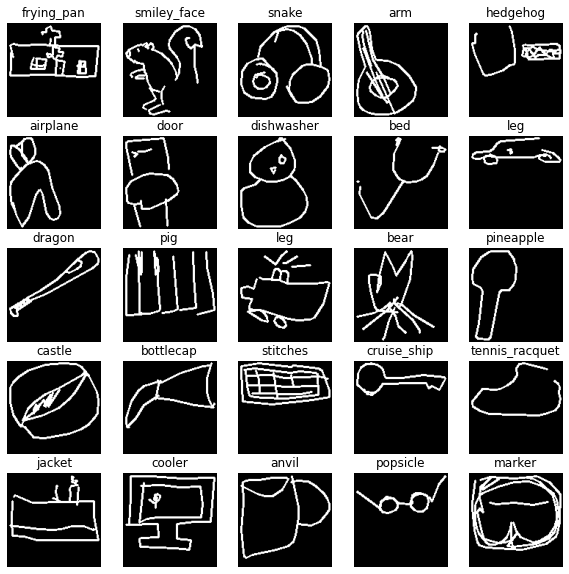

In [5]:
import matplotlib.pyplot as plt

# 파일 경로 설정
gz_data_folder_path = './data'
gz_train_file_path = os.path.join(gz_data_folder_path, 'train_simplified')
base_path = gz_train_file_path + '/shuffle_raw_gzs'
num_files = 100  # 파일 개수
df_files = [os.path.join(base_path, f'train_k{k}.gz') for k in range(num_files)]

# 파일 리스트 확인
print("경량화 시킨 gz 파일의 수:", len(df_files))

# Img_data_generator 인스턴스 생성
input_shape = (128, 128, 3)  # 입력 이미지의 형태 
batch_size = 25  # 배치 사이즈

"""
Img_data_generator 클래스의 인스턴스 생성
- df_files: 데이터프레임 파일 리스트
- input_shape: 입력 이미지의 형태 (높이, 너비, 채널)
- batchsize: 배치 크기
- label_names: 레이블 이름 리스트
- state: 상태 (DataCheck 상태에서 생성)
- lw: 선의 너비 (기본값은 2)
"""
gen_data_check = Img_data_generator(df_files, input_shape=input_shape, batchsize=batch_size, label_names=label_names, state='DataCheck', lw=2)

# print(gen_data_check[0])

# 첫 번째 배치 데이터 가져오기 및 시각화
xx, y = gen_data_check[0]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
labels = np.argmax(y, axis=1)  # 레이블 인덱스

# 이미지를 0에서 1 사이의 값으로 변환
xx = xx.astype(float) / 255.0

# 5x5 그리드에서 각 셀에 대해 이미지를 시각화하는 반복문
for i in range(25):
    axs[i // 5, i % 5].imshow(xx[i])  # 이미지 플로팅
    axs[i // 5, i % 5].axis('off')  # 축 숨기기
    axs[i // 5, i % 5].set_title(gen_data_check.label_names[labels[i]])  # 레이블 이름 설정

plt.show()

- 기본적인 이미지의 픽셀값이 0 ~ 1이 아닌 0 ~ 255사이의 값을 갖고 있기 때문에 0 ~ 1로 변환하여 그림을 그리도록 설정했습니다.
- 각 이미지에 대한 label은 정상적으로 연결된 것으로 보여집니다.

### STEP 04. 모델에 입력하기 (feat. Basic CNN)

- Img_data_generator를 사용해 100개의 chunk된 ~.gz 파일에서 데이터를 추출하여 지정한 batch_size만큼만 모델에 입력합니다.
- 이 코드는CNN 모델을 정의하고, 컴파일 및 학습하는 과정입니다. 
- 먼저, 데이터 파일을 준비하고, 이를 바탕으로 이미지 데이터 제너레이터 인스턴스를 생성합니다. 
    - 텐서플로우 데이터셋으로 변환
- 그 후, `Sequential` 모델을 사용하여 CNN 모델을 구성하고, 이 모델을 컴파일합니다. 
- 마지막으로, 생성된 데이터 제너레이터를 사용하여 모델을 학습시킵니다. 
- 모델은 두 개의 컨볼루션 레이어와 최대 풀링 레이어, 그리고 완전 연결 레이어를 포함합니다.

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. 데이터 파일 준비
data_folder_path = './data'
train_file_path = os.path.join(data_folder_path, 'train_simplified')
base_path = 'data/train_simplified/shuffle_raw_gzs'
num_files = 100
df_files = [os.path.join(base_path, f'train_k{k}.gz') for k in range(num_files)]

# 2. 제너레이터 인스턴스 생성
input_shape = (128, 128, 3)
batch_size = 32
train_generator = Img_data_generator(df_files, input_shape=input_shape, batchsize=batch_size, label_names=label_names, state='Train', lw=3)

# 3. TensorFlow dataset 생성 - from_generator method 사용
dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Image tensor
        tf.TensorSpec(shape=(None, len(label_names)), dtype=tf.int16)  # Label tensor
    )
)

# shuffle and prefetch the dataset
dataset = dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# 4. 모델 정의 (기본 CNN모델 사용)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_names), activation='softmax')  # 클래스 개수에 맞게 출력층 설정
])


# 5. 모델 컴파일
with tf.device('/GPU:0'):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. 모델 학습
with tf.device('/GPU:0'):
    model.fit(dataset, epochs=2, steps_per_epoch=len(train_generator))

Epoch 1/2
  430/15569 [..............................] - ETA: 39:02 - loss: 0.0000e+00 - accuracy: 0.0028

- 위 코드로 학습 시도를 했을 경우

```
Epoch 1/2
  430/15569 [..............................] - ETA: 39:02 - loss: 0.0000e+00 - accuracy: 0.0028
```

- 로 한 에포크당 약 40분 소요 예상
- 이전 파이프라인에서는 5시간 소요를 예상했기 때문에 훨씬 절약된걸 확인
- 현재까지의 메모리 사용은 `2928MiB / 15109MiB`이고, 이정도면 안정적으로 모델 학습을 할수 있지 않을까 예상 **=> but kernel dead..**
- ~오늘 미팅에서 이 내용을 공유하고 승순님이 제안한 모델 훈련 방식중에 아래 1번 방식으로 모델 학습 시도~

> 1) Pre-training : chunk한 파일들을 일부만 활용해서 샘플링된 데이터로 Pre-training을 시킨뒤에 튜닝을 진행하거나 데이터 투입량을 점진적으로 증가시키며 학습
